In [1]:
# C:\pytest\뉴스데이터
# 뉴스데이터_train.csv
# 뉴스데이터_test.csv
import pandas as pd
path = "c:\\pytest\\뉴스데이터\\"
train_df = pd.read_csv(path+"뉴스데이터_train.csv", encoding='cp949')
test_df = pd.read_csv(path+"뉴스데이터_test.csv", encoding='cp949')

In [2]:
data1_train = train_df.copy()
data1_test = test_df.copy()

data2_train = train_df.copy()
data2_test = test_df.copy()

In [3]:
data1_train.drop(['id','날짜','분류2'], axis=1, inplace=True)
data1_test.drop(['id','날짜','분류2'], axis=1, inplace=True)
data1_train['분류1_상위']=data1_train['분류1'].apply(lambda x:x.split(',')[0])
data1_test['분류1_상위']=data1_test['분류1'].apply(lambda x:x.split(',')[0])

In [4]:
data2_train.drop(['id','날짜','분류1'], axis=1, inplace=True)
data2_test.drop(['id','날짜','분류1'], axis=1, inplace=True)

In [5]:
data2_train.dropna(inplace=True)
data2_test.dropna(inplace=True)

In [6]:
data2_train['분류2_상위']=data2_train['분류2'].apply(lambda x:x.split(',')[0])
data2_test['분류2_상위']=data2_test['분류2'].apply(lambda x:x.split(',')[0])

In [7]:
import rhinoMorph

rn = rhinoMorph.startRhino()
def morphing(text):
    morphed = rhinoMorph.onlyMorph_list(rn, text, pos=['NNG', 'NNP', 'NP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'])
    return ' '.join(morphed)


filepath:  c:\projects\venv\lib\site-packages
classpath:  c:\projects\venv\lib\site-packages\rhinoMorph/lib/rhino.jar
RHINO started!


In [8]:
data1_train['텍스트'] = data1_train['텍스트'].apply(morphing)
data1_test['텍스트'] = data1_test['텍스트'].apply(morphing)
data2_train['텍스트'] = data2_train['텍스트'].apply(morphing)
data2_test['텍스트'] = data2_test['텍스트'].apply(morphing)

In [9]:
data1_train = pd.concat([data1_train, pd.get_dummies(data1_train['분류1_상위'])], axis=1) 
data1_test = pd.concat([data1_test, pd.get_dummies(data1_test['분류1_상위'])], axis=1) 
data2_train = pd.concat([data2_train, pd.get_dummies(data2_train['분류2_상위'])], axis=1) 
data2_test = pd.concat([data2_test, pd.get_dummies(data2_test['분류2_상위'])], axis=1) 

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# 여기부터
import math
import numpy as np

text_len= [len(line.split(' ')) for line in data1_train['텍스트']]
print("최소길이: ", np.min(text_len))
print("최대길이: ", np.max(text_len))
print("평균길이: ", np.round(np.mean(text_len), 1))
print("중위수길이: ", np.median(text_len))
print("구간별최대길이: ", np.percentile(text_len, [0, 25, 50, 75, 90, 100]))

max_words = 10000
max_len = 30


최소길이:  4
최대길이:  54
평균길이:  19.7
중위수길이:  19.0
구간별최대길이:  [ 4. 16. 19. 22. 27. 54.]


In [16]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data1_train['텍스트'])
word_index = tokenizer.word_index

data1_test['정치'] = 0
data1_test = data1_test[data1_train.columns]

data1_X_train = pad_sequences(tokenizer.texts_to_sequences(data1_train['텍스트']), maxlen=max_len)
data1_y_train = np.asarray(data1_train.iloc[:,-9:]).astype('float')
data1_X_test = pad_sequences(tokenizer.texts_to_sequences(data1_test['텍스트']), maxlen=max_len)
data1_y_test = np.asarray(data1_test.iloc[:,-9:]).astype('float')


In [17]:
len(word_index)+1

18072

In [18]:
data2_X_train = pad_sequences(tokenizer.texts_to_sequences(data2_train['텍스트']), maxlen=max_len)
data2_y_train = np.asarray(data2_train.iloc[:,-8:]).astype('float')
data2_X_test = pad_sequences(tokenizer.texts_to_sequences(data2_test['텍스트']), maxlen=max_len)
data2_y_test = np.asarray(data2_test.iloc[:,-8:]).astype('float')


In [19]:
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN
from tensorflow.keras import models
embedding_dim = 200

model = models.Sequential()
model.add(Embedding(input_dim=max_words, output_dim = embedding_dim, input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(32, 'relu'))
model.add(Dense(len(data1_y_train[0]), 'softmax'))

model.summary()
model.compile('rmsprop', 'categorical_crossentropy', 'acc')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 200)           2000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                16960     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 297       
Total params: 2,019,337
Trainable params: 2,019,337
Non-trainable params: 0
_________________________________________________________________


In [180]:
model.fit(data1_X_train, data1_y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
213/213 [==============================] - 9s 39ms/step - loss: 1.5377 - acc: 0.4516
Epoch 2/30
213/213 [==============================] - 9s 41ms/step - loss: 1.0013 - acc: 0.6441
Epoch 3/30
213/213 [==============================] - 9s 44ms/step - loss: 0.6667 - acc: 0.7599
Epoch 4/30
213/213 [==============================] - 9s 43ms/step - loss: 0.3552 - acc: 0.8869
Epoch 5/30
213/213 [==============================] - 9s 43ms/step - loss: 0.1476 - acc: 0.9586
Epoch 6/30
213/213 [==============================] - 9s 43ms/step - loss: 0.0510 - acc: 0.9870
Epoch 7/30
213/213 [==============================] - 9s 44ms/step - loss: 0.0247 - acc: 0.9946
Epoch 8/30
213/213 [==============================] - 10s 46ms/step - loss: 0.0122 - acc: 0.9963
Epoch 9/30
213/213 [==============================] - 10s 46ms/step - loss: 0.0066 - acc: 0.9976
Epoch 10/30
213/213 [==============================] - 9s 42ms/step - loss: 0.0039 - acc: 0.9984
Epoch 11/30
213/213 [================

In [181]:
model.evaluate(data1_X_test, data1_y_test)

71/71 [==============================] - 1s 10ms/step - loss: 4.0671 - acc: 0.5832


[4.067142009735107, 0.5832229852676392]

In [176]:
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN
from tensorflow.keras import models
embedding_dim = 200

model = models.Sequential()
model.add(Embedding(input_dim=max_words, output_dim = embedding_dim, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(32, 'relu'))
model.add(Dense(len(data1_y_train[0]), 'softmax'))

model.summary()
model.compile('rmsprop', 'categorical_crossentropy', 'acc')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 30, 200)           2000000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                67840     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 9)                 297       
                                                                 
Total params: 2,070,217
Trainable params: 2,070,217
Non-trainable params: 0
_________________________________________________________________


In [177]:
model.fit(data1_X_train, data1_y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
213/213 [==============================] - 8s 26ms/step - loss: 1.3885 - acc: 0.4988
Epoch 2/30
213/213 [==============================] - 5s 25ms/step - loss: 0.8405 - acc: 0.7161
Epoch 3/30
213/213 [==============================] - 5s 25ms/step - loss: 0.5392 - acc: 0.8288
Epoch 4/30
213/213 [==============================] - 5s 25ms/step - loss: 0.3459 - acc: 0.8963
Epoch 5/30
213/213 [==============================] - 5s 25ms/step - loss: 0.2233 - acc: 0.9329
Epoch 6/30
213/213 [==============================] - 5s 25ms/step - loss: 0.1434 - acc: 0.9561
Epoch 7/30
213/213 [==============================] - 5s 25ms/step - loss: 0.0883 - acc: 0.9750
Epoch 8/30
213/213 [==============================] - 5s 25ms/step - loss: 0.0544 - acc: 0.9848
Epoch 9/30
213/213 [==============================] - 5s 25ms/step - loss: 0.0377 - acc: 0.9878
Epoch 10/30
213/213 [==============================] - 5s 25ms/step - loss: 0.0231 - acc: 0.9923
Epoch 11/30
213/213 [==================

In [178]:
model.evaluate(data1_X_test, data1_y_test)

71/71 [==============================] - 1s 8ms/step - loss: 3.5290 - acc: 0.7170


[3.529014825820923, 0.7169978022575378]

In [174]:
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU
from tensorflow.keras import models
embedding_dim = 200

model = models.Sequential()
model.add(Embedding(input_dim=max_words, output_dim = embedding_dim, input_length=max_len))
model.add(GRU(64))
model.add(Dense(32, 'relu'))
model.add(Dense(len(data1_y_train[0]), 'softmax'))

model.summary()
model.compile('rmsprop', 'categorical_crossentropy', 'acc')

model.fit(data1_X_train, data1_y_train, epochs=30, batch_size=32, verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 30, 200)           2000000   
                                                                 
 gru (GRU)                   (None, 64)                51072     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 9)                 297       
                                                                 
Total params: 2,053,449
Trainable params: 2,053,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
213/213 [==============================] - 7s 24ms/step - loss: 1.4511 - acc: 0.4767
Epoch 2/30
213/213 [==============================] - 5s 24ms/step - loss: 0.892

In [175]:
model.evaluate(data1_X_test, data1_y_test)

71/71 [==============================] - 1s 7ms/step - loss: 4.1591 - acc: 0.6936


[4.159117221832275, 0.693598210811615]

In [182]:
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN
from tensorflow.keras import models
embedding_dim = 200

model = models.Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(32, 'relu'))
model.add(Dense(len(data2_y_train[0]), 'softmax'))

model.summary()
model.compile('rmsprop', 'categorical_crossentropy', 'acc')
model.fit(data2_X_train, data2_y_train, epochs=30, batch_size=32, verbose=1)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64)                16960     
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 8)                 264       
                                                                 
Total params: 2,019,304
Trainable params: 2,019,304
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
148/148 [==============================] - 8s 44ms/step - loss: 1.8275 - acc: 0.3180
Epoch 2/30
148/148 [==============================] - 7s 45ms/step - loss: 1.18

In [183]:
model.evaluate(data2_X_test, data2_y_test)

50/50 [==============================] - 1s 10ms/step - loss: 5.4772 - acc: 0.3622


[5.477198123931885, 0.362209677696228]

In [184]:
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN
from tensorflow.keras import models
embedding_dim = 200

model = models.Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(32, 'relu'))
model.add(Dense(len(data2_y_train[0]), 'softmax'))

model.summary()
model.compile('rmsprop', 'categorical_crossentropy', 'acc')
model.fit(data2_X_train, data2_y_train, epochs=30, batch_size=32, verbose=1)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 lstm_3 (LSTM)               (None, 64)                67840     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 8)                 264       
                                                                 
Total params: 2,070,184
Trainable params: 2,070,184
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
148/148 [==============================] - 5s 25ms/step - loss: 1.6580 - acc: 0.3905
Epoch 2/30
148/148 [==============================] - 4s 25ms/step - loss: 1.12

In [185]:
model.evaluate(data2_X_test, data2_y_test)

50/50 [==============================] - 1s 8ms/step - loss: 6.4730 - acc: 0.5794


[6.473018169403076, 0.5794098973274231]

In [186]:
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU
from tensorflow.keras import models
embedding_dim = 200

model = models.Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(GRU(64))
model.add(Dense(32, 'relu'))
model.add(Dense(len(data2_y_train[0]), 'softmax'))

model.summary()
model.compile('rmsprop', 'categorical_crossentropy', 'acc')
model.fit(data2_X_train, data2_y_train, epochs=30, batch_size=32, verbose=1)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 gru_1 (GRU)                 (None, 64)                51072     
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 8)                 264       
                                                                 
Total params: 2,053,416
Trainable params: 2,053,416
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
148/148 [==============================] - 5s 24ms/step - loss: 1.7654 - acc: 0.3230
Epoch 2/30
148/148 [==============================] - 4s 24ms/step - loss: 1.24

In [187]:
model.evaluate(data2_X_test, data2_y_test)

50/50 [==============================] - 1s 8ms/step - loss: 7.1964 - acc: 0.5443


[7.196388244628906, 0.5442560911178589]

In [204]:
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN
from tensorflow.keras import models
embedding_dim = 200

model = models.Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
# model.add(Embedding(input_dim=max_words, input_length=max_len,  output_dim=embedding_dim))
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
model.add(LSTM(64))
model.add(Dense(32, 'relu'))
model.add(Dense(16, 'relu'))
model.add(Dense(len(data2_y_train[0]), 'softmax'))

model.summary()
model.compile('rmsprop', 'categorical_crossentropy', 'acc')
model.fit(data2_X_train, data2_y_train, epochs=15, batch_size=32, verbose=1)
model.evaluate(data2_X_test, data2_y_test)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, None, 200)         2000000   
                                                                 
 lstm_20 (LSTM)              (None, 64)                67840     
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dense_51 (Dense)            (None, 8)                 136       
                                                                 
Total params: 2,070,584
Trainable params: 2,070,584
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
148/148 [=======================

[3.614398717880249, 0.5624607801437378]

### 분류1

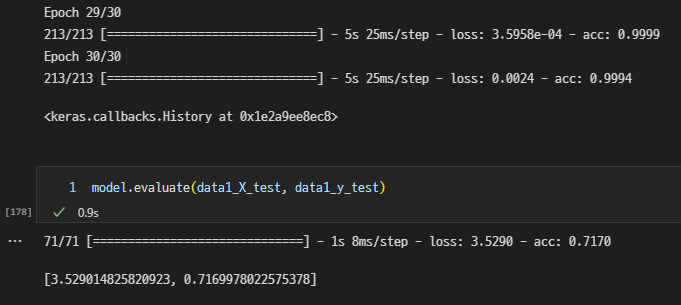

### 분류2

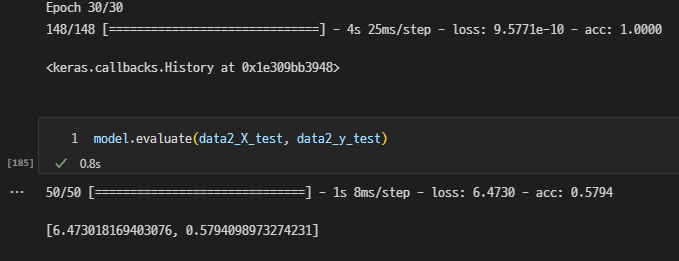

In [214]:
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN
from tensorflow.keras import models
embedding_dim = 200

model = models.Sequential()
model.add(Embedding(input_dim=max_words, output_dim = embedding_dim, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(32, 'relu'))
model.add(Dense(len(data1_y_train[0]), 'softmax'))

model.summary()
model.compile('adam', 'categorical_crossentropy', 'acc')

model.fit(data1_X_train, data1_y_train, epochs=30, batch_size=32, verbose=1, validation_data=(data1_X_test, data1_y_test))
model.evaluate(data1_X_test, data1_y_test)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 lstm_22 (LSTM)              (None, 64)                67840     
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 dense_55 (Dense)            (None, 9)                 297       
                                                                 
Total params: 2,070,217
Trainable params: 2,070,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
213/213 [==============================] - 12s 52ms/step - loss: 1.3927 - acc: 0.5107 - val_loss: 1.0969 - val_acc: 0.6243
Epoch 2/30
213/213 [=====================

[2.400740623474121, 0.7271523475646973]

In [215]:
model.evaluate(data1_X_test, data1_y_test)

71/71 [==============================] - 1s 8ms/step - loss: 2.4007 - acc: 0.7272


[2.400740623474121, 0.7271523475646973]

In [ ]:
# 워드임베딩_순환신경망
# 워드임베딩_순환신경망_l2규제설정
# 워드임베딩_순환신경망_dropout0.5
# 워드임베딩_dropout0.5
# 워드임베딩_양방향순환신경망

In [229]:
# 워드임베딩_순환신경망
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU
from tensorflow.keras import models, regularizers
embedding_dim = 200
model_워드임베딩_순환신경망 = models.Sequential()
model_워드임베딩_순환신경망.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_워드임베딩_순환신경망.add(LSTM(64))
model_워드임베딩_순환신경망.add(Dense(32, 'relu'))
model_워드임베딩_순환신경망.add(Dense(16, 'relu'))
model_워드임베딩_순환신경망.add(Dense(len(data1_y_train[0]), 'softmax'))
model_워드임베딩_순환신경망.summary()
model_워드임베딩_순환신경망.compile('rmsprop', 'categorical_crossentropy', 'acc')
history_워드임베딩_순환신경망 = model_워드임베딩_순환신경망.fit(data1_X_train, data1_y_train, epochs=15, batch_size=32, verbose=1, validation_data=(data1_X_test, data1_y_test))
model_워드임베딩_순환신경망.evaluate(data1_X_test, data1_y_test)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 lstm_29 (LSTM)              (None, 64)                67840     
                                                                 
 dense_86 (Dense)            (None, 32)                2080      
                                                                 
 dense_87 (Dense)            (None, 16)                528       
                                                                 
 dense_88 (Dense)            (None, 9)                 153       
                                                                 
Total params: 2,070,601
Trainable params: 2,070,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
213/213 [=======================

[2.4818332195281982, 0.7152317762374878]

In [230]:
# 워드임베딩_순환신경망_l2규제설정
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU
from tensorflow.keras import models, regularizers
embedding_dim = 200
model_워드임베딩_순환신경망_l2규제설정 = models.Sequential()
model_워드임베딩_순환신경망_l2규제설정.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_워드임베딩_순환신경망_l2규제설정.add(LSTM(64))
model_워드임베딩_순환신경망_l2규제설정.add(Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(max_words,)))
model_워드임베딩_순환신경망_l2규제설정.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_워드임베딩_순환신경망_l2규제설정.add(Dense(len(data1_y_train[0]), 'softmax'))
model_워드임베딩_순환신경망_l2규제설정.summary()
model_워드임베딩_순환신경망_l2규제설정.compile('rmsprop', 'categorical_crossentropy', 'acc')
history_워드임베딩_순환신경망_l2규제설정 = model_워드임베딩_순환신경망_l2규제설정.fit(data1_X_train, data1_y_train, epochs=15, batch_size=32, verbose=1, validation_data=(data1_X_test, data1_y_test))
model_워드임베딩_순환신경망_l2규제설정.evaluate(data1_X_test, data1_y_test)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 lstm_30 (LSTM)              (None, 64)                67840     
                                                                 
 dense_89 (Dense)            (None, 32)                2080      
                                                                 
 dense_90 (Dense)            (None, 16)                528       
                                                                 
 dense_91 (Dense)            (None, 9)                 153       
                                                                 
Total params: 2,070,601
Trainable params: 2,070,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
213/213 [=======================

[1.7314863204956055, 0.7183222770690918]

In [231]:
# 워드임베딩_순환신경망_dropout0.5
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU, Dropout
from tensorflow.keras import models, regularizers
embedding_dim = 200
model_워드임베딩_순환신경망_dropout = models.Sequential()
model_워드임베딩_순환신경망_dropout.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_워드임베딩_순환신경망_dropout.add(LSTM(64))
model_워드임베딩_순환신경망_dropout.add(Dense(32, activation='relu', input_shape=(max_words,)))
model_워드임베딩_순환신경망_dropout.add(Dropout(0.5))
model_워드임베딩_순환신경망_dropout.add(Dense(16, activation='relu'))
model_워드임베딩_순환신경망_dropout.add(Dropout(0.5))
model_워드임베딩_순환신경망_dropout.add(Dense(len(data1_y_train[0]), 'softmax'))
model_워드임베딩_순환신경망_dropout.summary()
model_워드임베딩_순환신경망_dropout.compile('rmsprop', 'categorical_crossentropy', 'acc')
history_워드임베딩_순환신경망_dropout = model_워드임베딩_순환신경망_dropout.fit(data1_X_train, data1_y_train, epochs=15, batch_size=32, verbose=1, validation_data=(data1_X_test, data1_y_test))
model_워드임베딩_순환신경망_dropout.evaluate(data1_X_test, data1_y_test)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 lstm_31 (LSTM)              (None, 64)                67840     
                                                                 
 dense_92 (Dense)            (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_93 (Dense)            (None, 16)                528       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_94 (Dense)            (None, 9)               

[2.894545793533325, 0.7037527561187744]

In [232]:
# 워드임베딩_dropout0.5
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU, Dropout
from tensorflow.keras import models, regularizers
embedding_dim = 200
model_워드임베딩_dropout = models.Sequential()
model_워드임베딩_dropout.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_워드임베딩_dropout.add(Flatten())
model_워드임베딩_dropout.add(Dense(32, activation='relu', input_shape=(max_words,)))
model_워드임베딩_dropout.add(Dropout(0.5))
model_워드임베딩_dropout.add(Dense(16, activation='relu'))
model_워드임베딩_dropout.add(Dropout(0.5))
model_워드임베딩_dropout.add(Dense(len(data1_y_train[0]), 'softmax'))
model_워드임베딩_dropout.summary()
model_워드임베딩_dropout.compile('rmsprop', 'categorical_crossentropy', 'acc')
history_워드임베딩_dropout = model_워드임베딩_dropout.fit(data1_X_train, data1_y_train, epochs=15, batch_size=32, verbose=1, validation_data=(data1_X_test, data1_y_test))
model_워드임베딩_dropout.evaluate(data1_X_test, data1_y_test)

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 flatten_1 (Flatten)         (None, 6000)              0         
                                                                 
 dense_95 (Dense)            (None, 32)                192032    
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_96 (Dense)            (None, 16)                528       
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_97 (Dense)            (None, 9)               

[2.0913233757019043, 0.7178807854652405]

In [233]:
# 워드임베딩_양방향순환신경망
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU, Dropout, Bidirectional
from tensorflow.keras import models, regularizers
embedding_dim = 200
model_워드임베딩_양방향순환신경망 = models.Sequential()
model_워드임베딩_양방향순환신경망.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_워드임베딩_양방향순환신경망.add(Bidirectional(LSTM(64)))
model_워드임베딩_양방향순환신경망.add(Dense(32, activation='relu', input_shape=(max_words,)))
model_워드임베딩_양방향순환신경망.add(Dense(16, activation='relu'))
model_워드임베딩_양방향순환신경망.add(Dense(len(data1_y_train[0]), 'softmax'))
model_워드임베딩_양방향순환신경망.summary()
model_워드임베딩_양방향순환신경망.compile('rmsprop', 'categorical_crossentropy', 'acc')
history_워드임베딩_양방향순환신경망 = model_워드임베딩_양방향순환신경망.fit(data1_X_train, data1_y_train, epochs=15, batch_size=32, verbose=1, validation_data=(data1_X_test, data1_y_test))
model_워드임베딩_양방향순환신경망.evaluate(data1_X_test, data1_y_test)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dense_98 (Dense)            (None, 32)                4128      
                                                                 
 dense_99 (Dense)            (None, 16)                528       
                                                                 
 dense_100 (Dense)           (None, 9)                 153       
                                                                 
Total params: 2,140,489
Trainable params: 2,140,489
Non-trainable params: 0
___________________________________________

[2.108600616455078, 0.7121412754058838]

In [ ]:
# history_워드임베딩_순환신경망
# history_워드임베딩_순환신경망_l2규제설정
# history_워드임베딩_순환신경망_dropout
# history_워드임베딩_dropout
# history_워드임베딩_양방향순환신경망

In [247]:
history_워드임베딩_양방향순환신경망.history.keys()


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

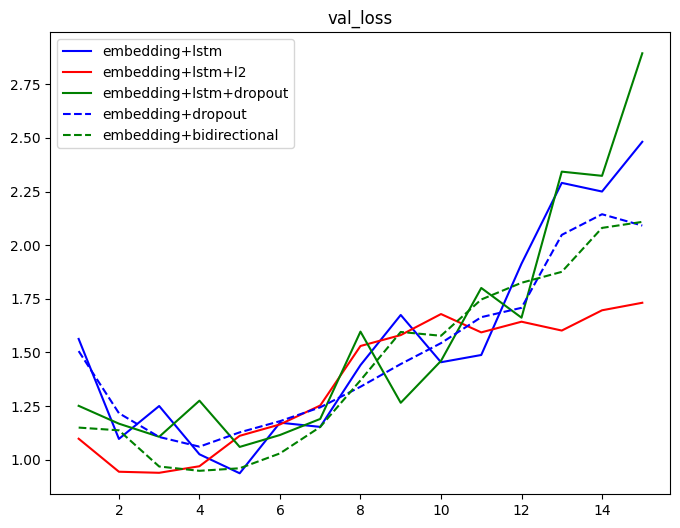

In [253]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
x=list(range(1,16))
plt.plot(x, history_워드임베딩_순환신경망.history['val_loss'],'b-',label='embedding+lstm')
plt.plot(x, history_워드임베딩_순환신경망_l2규제설정.history['val_loss'],'r-',label='embedding+lstm+l2')
plt.plot(x, history_워드임베딩_순환신경망_dropout.history['val_loss'],'g-',label='embedding+lstm+dropout')
plt.plot(x, history_워드임베딩_dropout.history['val_loss'],'b--',label='embedding+dropout')
plt.plot(x, history_워드임베딩_양방향순환신경망.history['val_loss'],'g--',label='embedding+bidirectional')
plt.title('val_loss')
plt.legend()
plt.show()

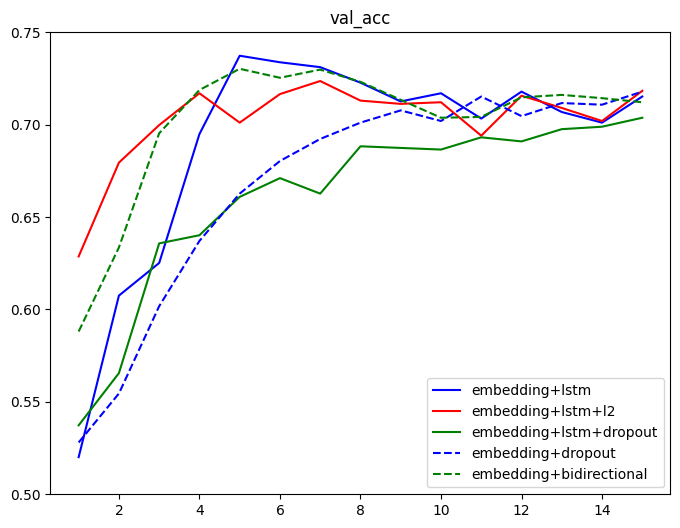

In [255]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
x=list(range(1,16))
plt.plot(x, history_워드임베딩_순환신경망.history['val_acc'],'b-',label='embedding+lstm')
plt.plot(x, history_워드임베딩_순환신경망_l2규제설정.history['val_acc'],'r-',label='embedding+lstm+l2')
plt.plot(x, history_워드임베딩_순환신경망_dropout.history['val_acc'],'g-',label='embedding+lstm+dropout')
plt.plot(x, history_워드임베딩_dropout.history['val_acc'],'b--',label='embedding+dropout')
plt.plot(x, history_워드임베딩_양방향순환신경망.history['val_acc'],'g--',label='embedding+bidirectional')
plt.title('val_acc')
plt.ylim(0.5,0.75)
plt.legend()
plt.show()

In [257]:
print("model_워드임베딩_순환신경망", model_워드임베딩_순환신경망.evaluate(data1_X_test, data1_y_test))
print()
print("model_워드임베딩_순환신경망_l2규제설정", model_워드임베딩_순환신경망_l2규제설정.evaluate(data1_X_test, data1_y_test))
print()
print("model_워드임베딩_순환신경망_dropout", model_워드임베딩_순환신경망_dropout.evaluate(data1_X_test, data1_y_test))
print()
print("model_워드임베딩_dropout", model_워드임베딩_dropout.evaluate(data1_X_test, data1_y_test))
print()
print("model_워드임베딩_양방향순환신경망", model_워드임베딩_양방향순환신경망.evaluate(data1_X_test, data1_y_test))
print()


71/71 [==============================] - 1s 8ms/step - loss: 2.4818 - acc: 0.7152
model_워드임베딩_순환신경망 [2.4818332195281982, 0.7152317762374878]

71/71 [==============================] - 1s 8ms/step - loss: 1.7315 - acc: 0.7183
model_워드임베딩_순환신경망_l2규제설정 [1.7314863204956055, 0.7183222770690918]

71/71 [==============================] - 1s 8ms/step - loss: 2.8945 - acc: 0.7038
model_워드임베딩_순환신경망_dropout [2.894545793533325, 0.7037527561187744]

71/71 [==============================] - 0s 4ms/step - loss: 2.0913 - acc: 0.7179
model_워드임베딩_dropout [2.0913233757019043, 0.7178807854652405]

71/71 [==============================] - 1s 14ms/step - loss: 2.1086 - acc: 0.7121
model_워드임베딩_양방향순환신경망 [2.108600616455078, 0.7121412754058838]



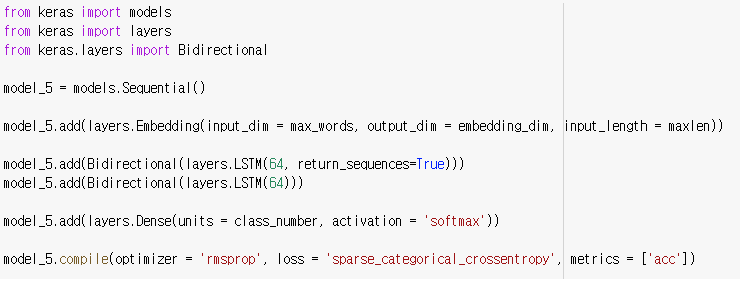

In [258]:
# 워드임베딩_양방향순환신경망
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU, Dropout, Bidirectional
from tensorflow.keras import models, regularizers
embedding_dim = 200
model_X = models.Sequential()
model_X.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_X.add(Bidirectional(LSTM(64, return_sequences=True)))
model_X.add(Bidirectional(LSTM(64)))
model_X.add(Dense(len(data1_y_train[0]), 'softmax'))
model_X.summary()
model_X.compile('rmsprop', 'categorical_crossentropy', 'acc')
history_X = model_X.fit(data1_X_train, data1_y_train, epochs=15, batch_size=32, verbose=1, validation_data=(data1_X_test, data1_y_test))
model_X.evaluate(data1_X_test, data1_y_test)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 30, 200)           2000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 128)          135680    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_101 (Dense)           (None, 9)                 1161      
                                                                 
Total params: 2,235,657
Trainable params: 2,235,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
213/213 [=======================

[2.1916494369506836, 0.7121412754058838]

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv2D, Conv1D, MaxPool2D, Dropout, LSTM, MaxPooling1D, MaxPooling2D, Flatten, Dropout
embedding_dim = 200


In [ ]:
# model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
# model.add(Conv1D(32, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))
# model.add(LSTM(32))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()
# model.compile('rmsprop','binary_crossentropy','acc')

In [22]:
# 워드임베딩_양방향순환신경망
from tensorflow.keras.layers import Dense, Embedding, RNN, LSTM, Flatten, SimpleRNN, GRU, Dropout, Bidirectional
from tensorflow.keras import models, regularizers
embedding_dim = 200
model_X = models.Sequential()
model_X.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_X.add(Conv1D(32, kernel_size=3, activation='relu'))
model_X.add(MaxPooling1D(pool_size=2))
model_X.add(Bidirectional(LSTM(64, return_sequences=True)))
model_X.add(Bidirectional(LSTM(64)))
model_X.add(Dense(len(data1_y_train[0]), 'softmax'))
model_X.summary()
model_X.compile('rmsprop', 'categorical_crossentropy', 'acc')
history_X = model_X.fit(data1_X_train, data1_y_train, epochs=15, batch_size=32, verbose=1, validation_data=(data1_X_test, data1_y_test))
model_X.evaluate(data1_X_test, data1_y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 200)           2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 32)            19232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 14, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1161      
Total params: 2,168,873
Trainable params: 2,168,873
Non-trainable params: 0
____________________________________________

[2.040797472000122, 0.7139073014259338]

In [24]:
print("""
71/71 [==============================] - 1s 8ms/step - loss: 2.4818 - acc: 0.7152
model_워드임베딩_순환신경망 [2.4818332195281982, 0.7152317762374878]

71/71 [==============================] - 1s 8ms/step - loss: 1.7315 - acc: 0.7183
model_워드임베딩_순환신경망_l2규제설정 [1.7314863204956055, 0.7183222770690918]

71/71 [==============================] - 1s 8ms/step - loss: 2.8945 - acc: 0.7038
model_워드임베딩_순환신경망_dropout [2.894545793533325, 0.7037527561187744]

71/71 [==============================] - 0s 4ms/step - loss: 2.0913 - acc: 0.7179
model_워드임베딩_dropout [2.0913233757019043, 0.7178807854652405]

71/71 [==============================] - 1s 14ms/step - loss: 2.1086 - acc: 0.7121
model_워드임베딩_양방향순환신경망 [2.108600616455078, 0.7121412754058838]
""")
print("model_워드임베딩_Conv1d_양방향순환신경망", model_X.evaluate(data1_X_test, data1_y_test))
print()


71/71 [==============================] - 1s 8ms/step - loss: 2.4818 - acc: 0.7152
model_워드임베딩_순환신경망 [2.4818332195281982, 0.7152317762374878]

71/71 [==============================] - 1s 8ms/step - loss: 1.7315 - acc: 0.7183
model_워드임베딩_순환신경망_l2규제설정 [1.7314863204956055, 0.7183222770690918]

71/71 [==============================] - 1s 8ms/step - loss: 2.8945 - acc: 0.7038
model_워드임베딩_순환신경망_dropout [2.894545793533325, 0.7037527561187744]

71/71 [==============================] - 0s 4ms/step - loss: 2.0913 - acc: 0.7179
model_워드임베딩_dropout [2.0913233757019043, 0.7178807854652405]

71/71 [==============================] - 1s 14ms/step - loss: 2.1086 - acc: 0.7121
model_워드임베딩_양방향순환신경망 [2.108600616455078, 0.7121412754058838]

71/71 [==============================] - 0s 5ms/step - loss: 2.0408 - acc: 0.7139
model_워드임베딩_Conv1d_양방향순환신경망 [2.040797472000122, 0.7139073014259338]

